<style>
body, .rendered_html, .CodeMirror, .output {
    font-family: "Courier New", monospace;
    font-size: 16px;
}
</style>


## ORFEUS webinar

# How to curate and check seismic station metadata
31 May 2024

1. Metadata curation
2. Station Metadata Changelog API
3. Example: Station Metadata Changelog API request

# 1. Metadata curation
___

## Typical workflow for a network curator for metadata updates
- Mostly manual work
- Variety of exceptions to cover
- Metadata is critical
- SCML preferred (no conversion)

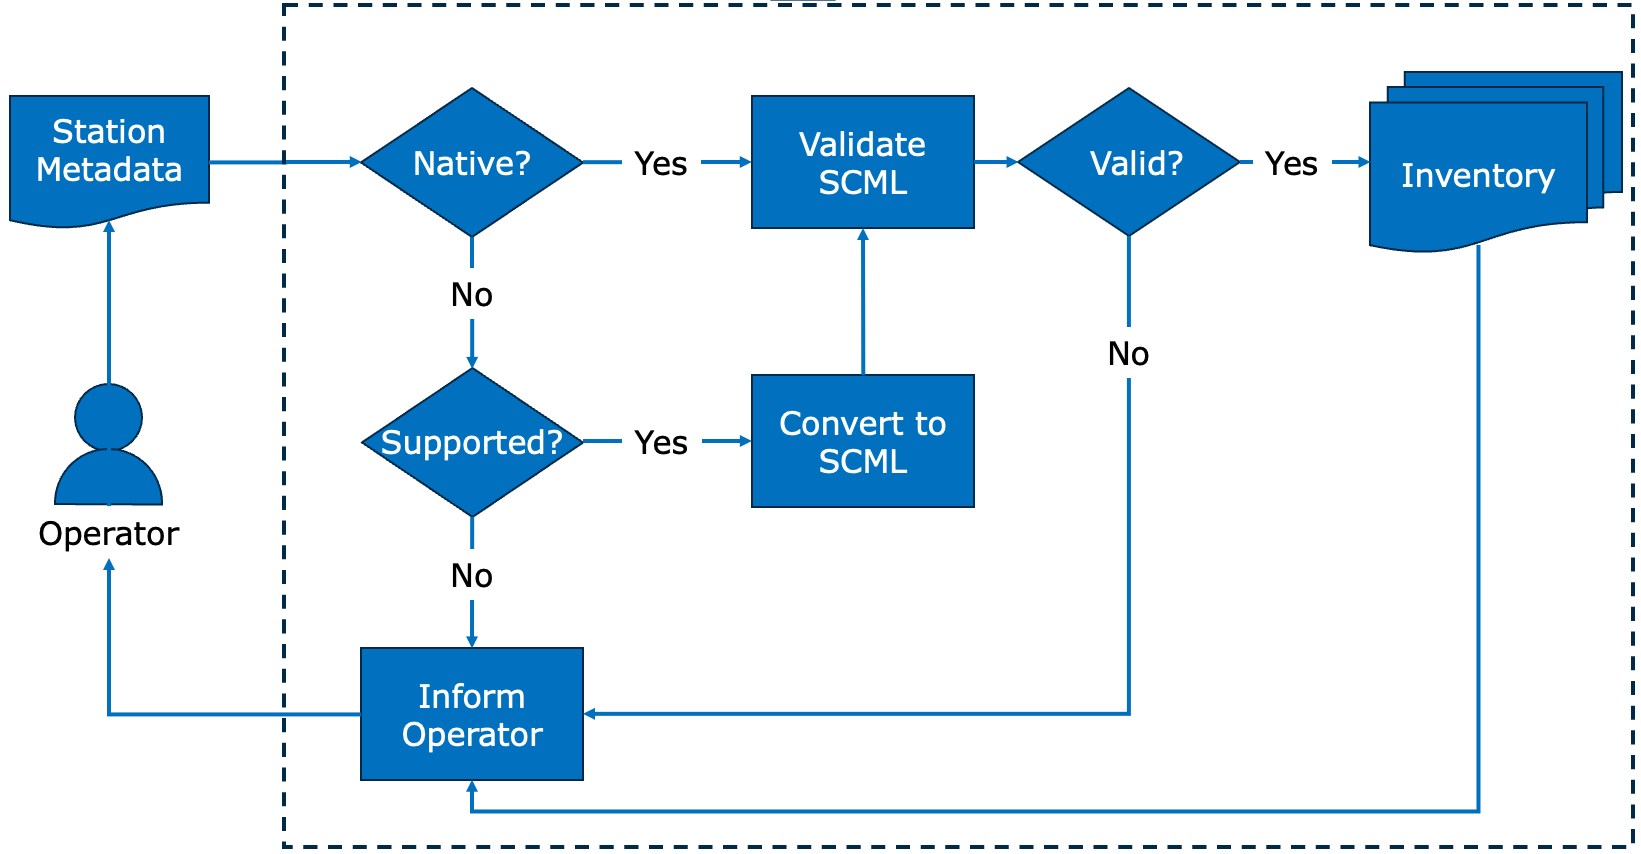

## Tools
There is a pool of tools available for maintaining metadata, for example:

- [NRL](https://ds.iris.edu/ds/nrl/) - *Build your own response*
- [ObsPy](https://docs.obspy.org) - *Python framework for processing seismological data, supports various metadataformats, open-source*
- [gempa: Station Management Portal](https://smp.gempa.de/) - *Online metadata management portal, only supports SCML*
- [Yasmine](https://github.com/iris-edu/yasmine-stationxml-editor) - *Python web application to create and edit geophysical station metadata information in FDSN stationXML format*
- [obsinfo](https://obsinfo.readthedocs.io/en/master/) - *a Python standalone application for creating FDSN-standard (StationXML) data and metadata for ocean bottom seismometer*

## Metadata formats

<br/>

- SeisComP native
  - SCML 0.11, 0.12, 0.13 (depending on SeisComP version)
- Nonnative (conversion to SCML required before uploading to the inventory):
  - StationXML 1.1, 1.2
  - Dataless SEED (preferrably not)

<br/>

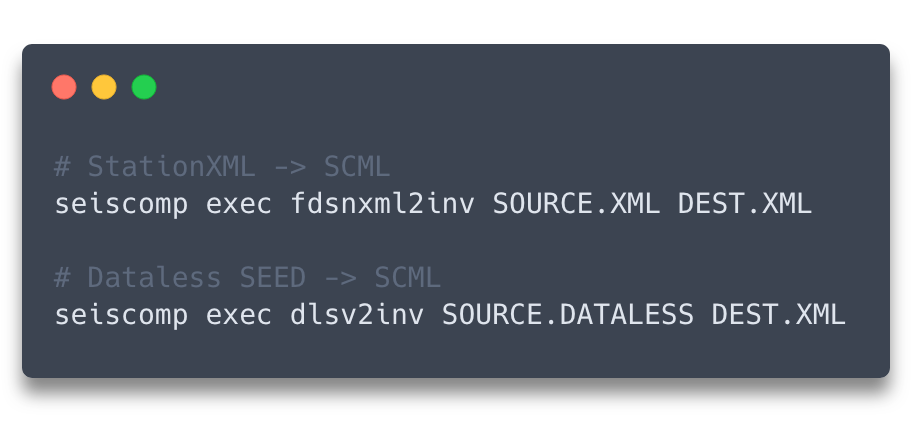

<br/>
<br/>

## Validation
### Validation using SeisComP (OK)

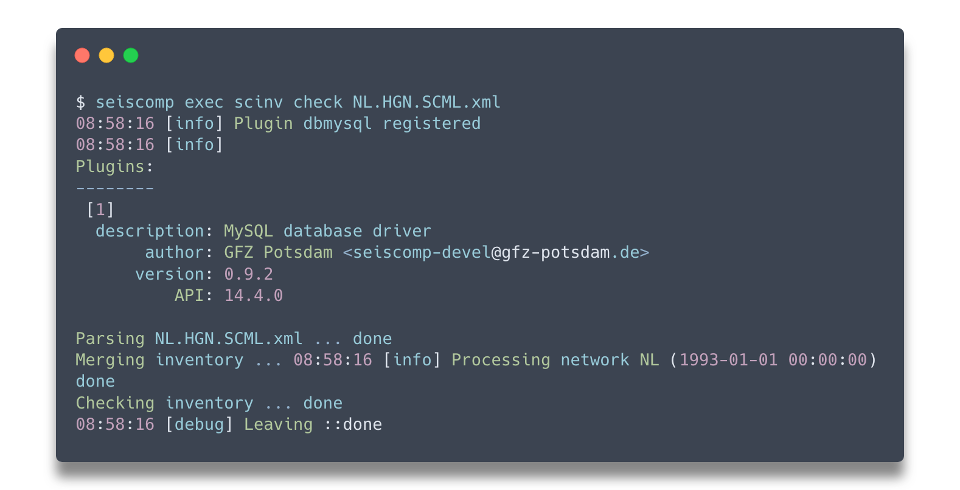

### Validation using SeisComP (Not OK)
Start time of NL.HGN.BHE channel is later than end time.

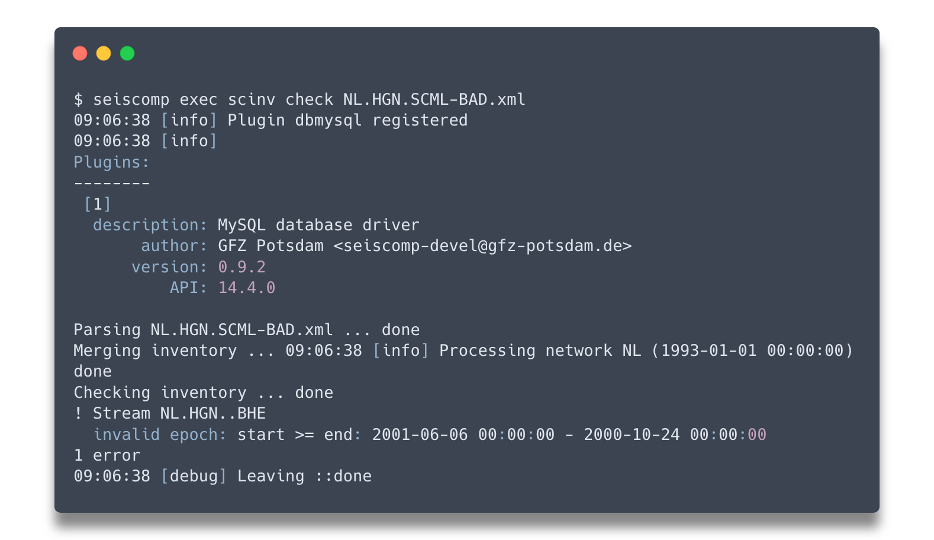

### Validation using python/xmlschema

In [18]:
import xmlschema
if xmlschema.is_valid("./data/good_example.xml", "./data/fdsn-station-1.2.xsd"):
    print("Valid StationXML!")

Valid StationXML!


In [19]:
if xmlschema.is_valid("./data/bad_example.xml", "./data/fdsn-station-1.2.xsd"):
    print("Valid StationXML!")
else:
    try:
        xmlschema.validate("./data/bad_example.xml", "./data/fdsn-station-1.2.xsd")
    except xmlschema.XMLSchemaValidationError as validation_error:
        print(validation_error)

failed validating {'startDate': '2002-11-19T21:07:00Z'} with XsdAttributeGroup(['alternateCode', 'code', 'endDate', 'historicalCode', 'restrictedStatus', 'sourceID', 'startDate', XsdAnyAttribute(namespace=['##other'], process_contents='lax')]):

Reason: missing required attribute 'code'

Schema component:

  <xs:extension xmlns:xs="http://www.w3.org/2001/XMLSchema" base="fsx:BaseNodeType">
              <xs:sequence>
                  <xs:element name="Latitude" type="fsx:LatitudeType">
                      <xs:annotation>
      <xs:documentation>Station latitude, in degrees. Where the bulk of the equipment is located (or another appropriate site location).
    The unit is fixed to be degrees, and datum defaults to WGS84.
  </xs:documentation>
      <xs:documentation><example><Latitude>34.9459</Latitude></example></xs:documentation>
                      </xs:annotation>
                  </xs:element>
                  <xs:element name="Longitude" type="fsx:LongitudeType">
          

## How to mantain network quality
- Per station PPSD
- Single frequency over time of PPSD to check effect of response change

### Teleseimic events
Teleseismic events should have similar response at nearby stations after instrument response removal.

Example event: **M8.2, Fiji, 2018-08-19 00:19:40 (UTC)**

Example network: part of **NL**

These stations look ok, except some irregularities in amplitude at station 75-84

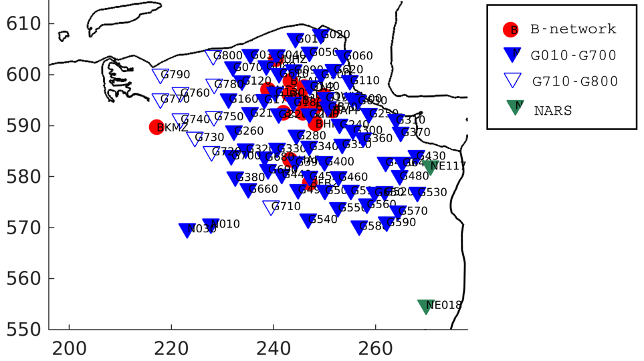
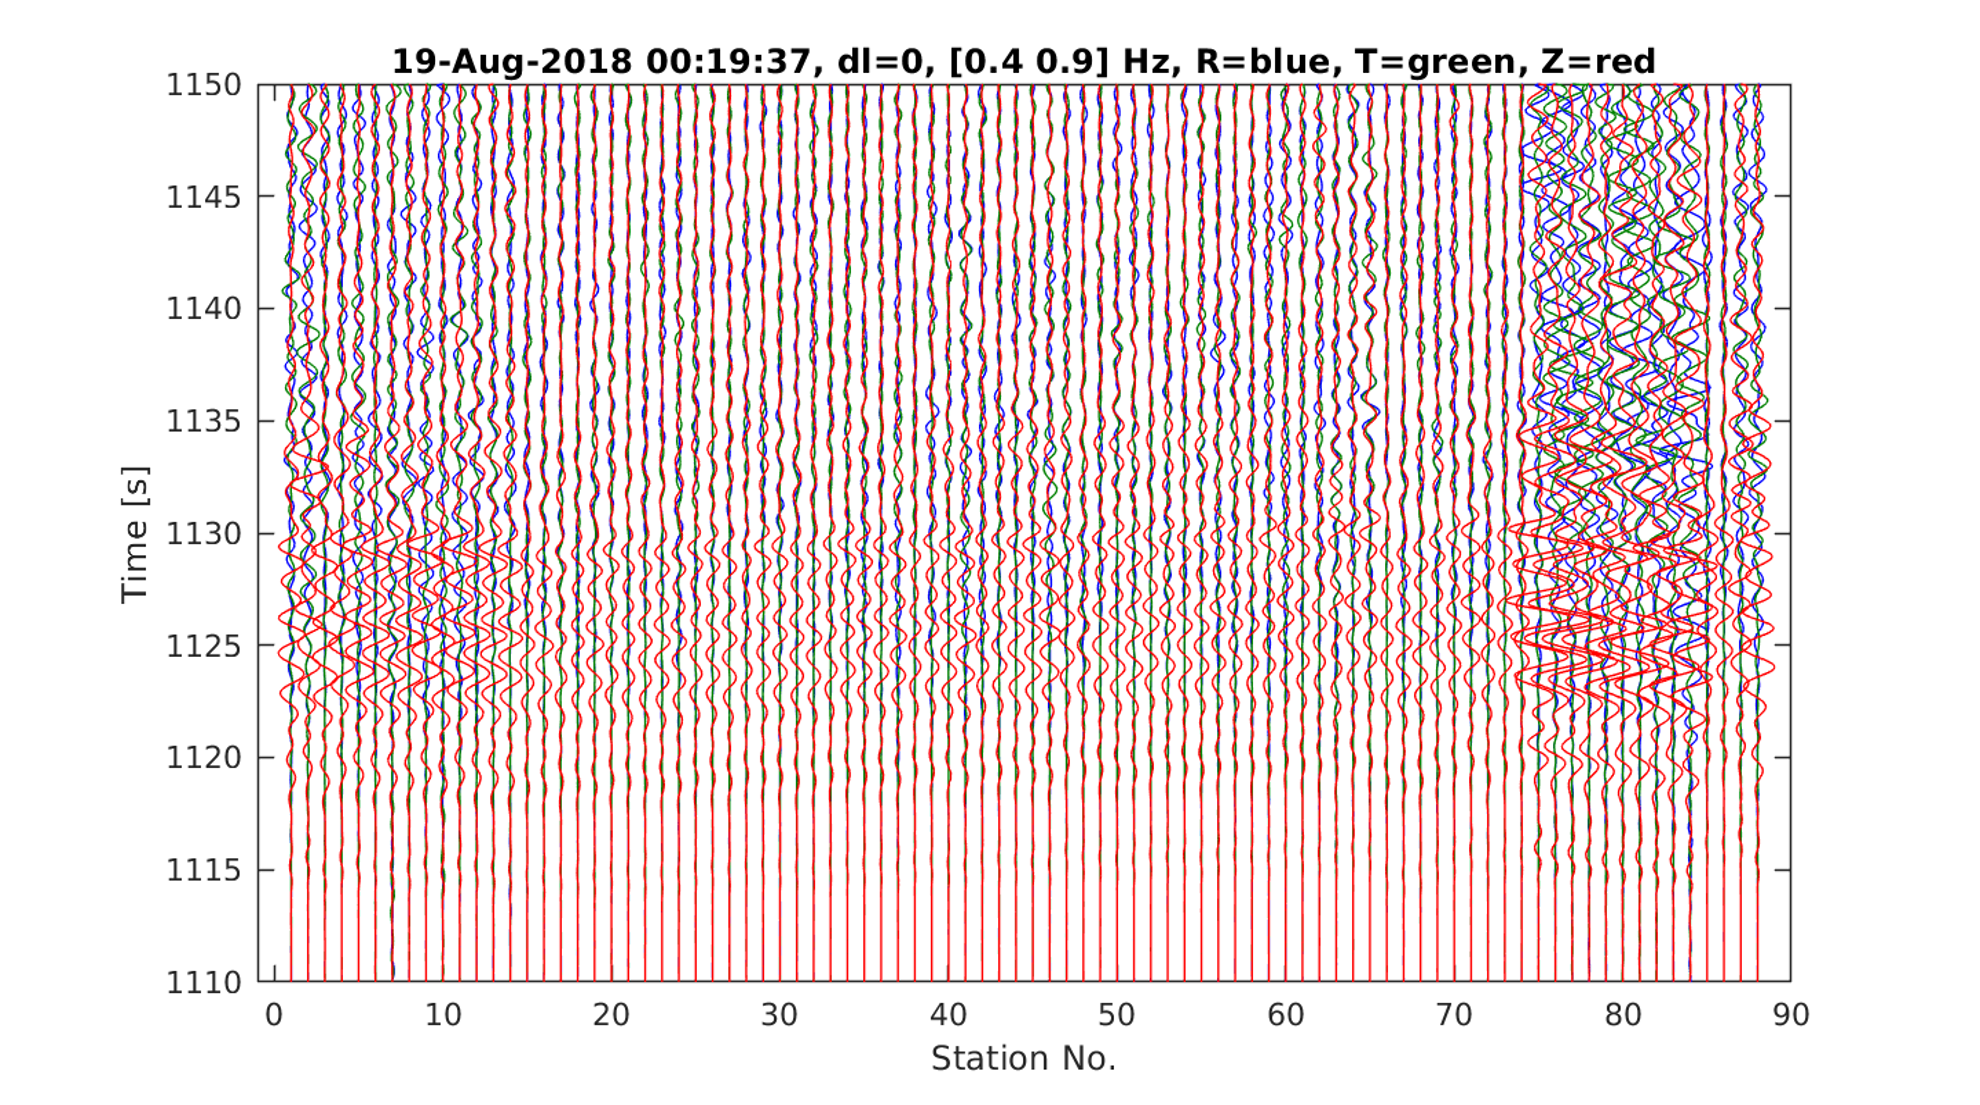

<div style="text-align:center">
    <!-- 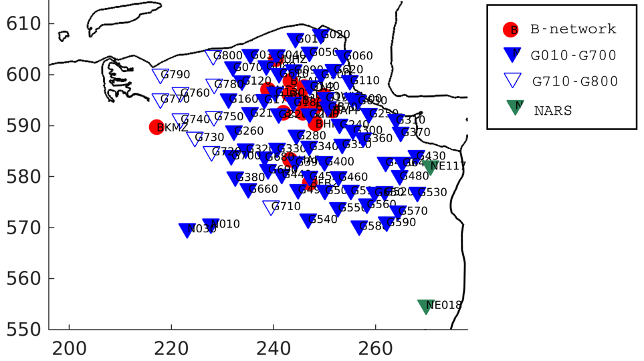
    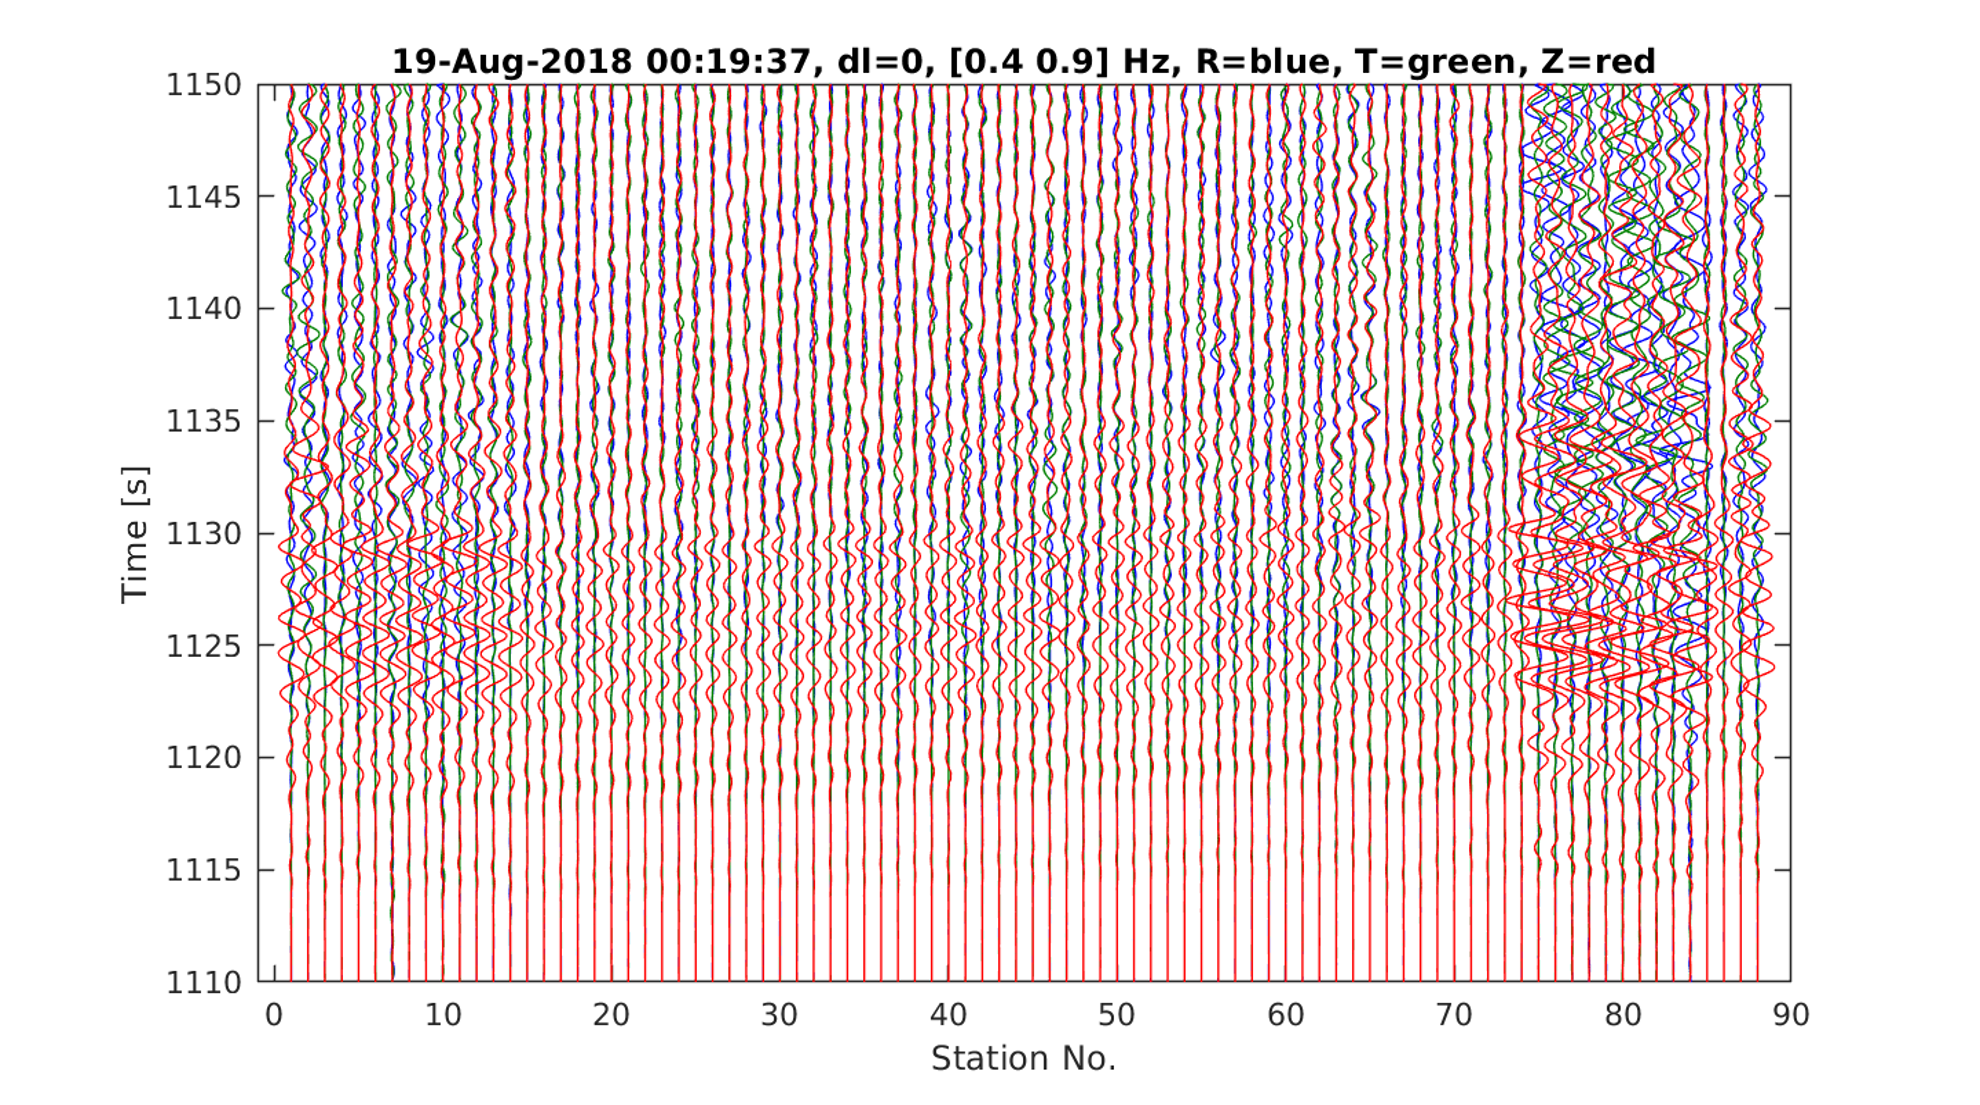 -->
    source: Elmer Ruigrok (KNMI)
</div>


## Responsibilities of network curator
- Only validation of metadata
  - technical details are maintained by the metadata operator
- For best practice, check for instance the seed manual
- For EIDA: As long as the xml is valid, it is accepted

## Example of problematic metadata: Raspberry Shake
- Sensors get fixed seed id and are subsequently move to new locations
- Difficult to keep track of history of sensor and usability of data

# 2. Station Metadata Changelog API
___

Practical and simple way to log and publish metadata changes.

Two parts
- Harvester: logs metadata changes of datacenter FDSNWS
- API: Returns metadata changes and timeline

## Harvester – A very basic outline 

- Periodically checks datacenter FDSNWS
- Requirements:
    - FDSNWS-Station
    - Network DOI



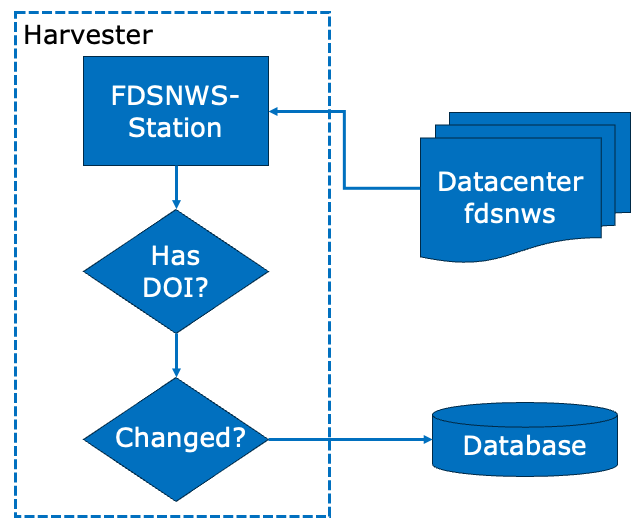

## API - Methods
### Query
Get station metadata changelog in a given time-window
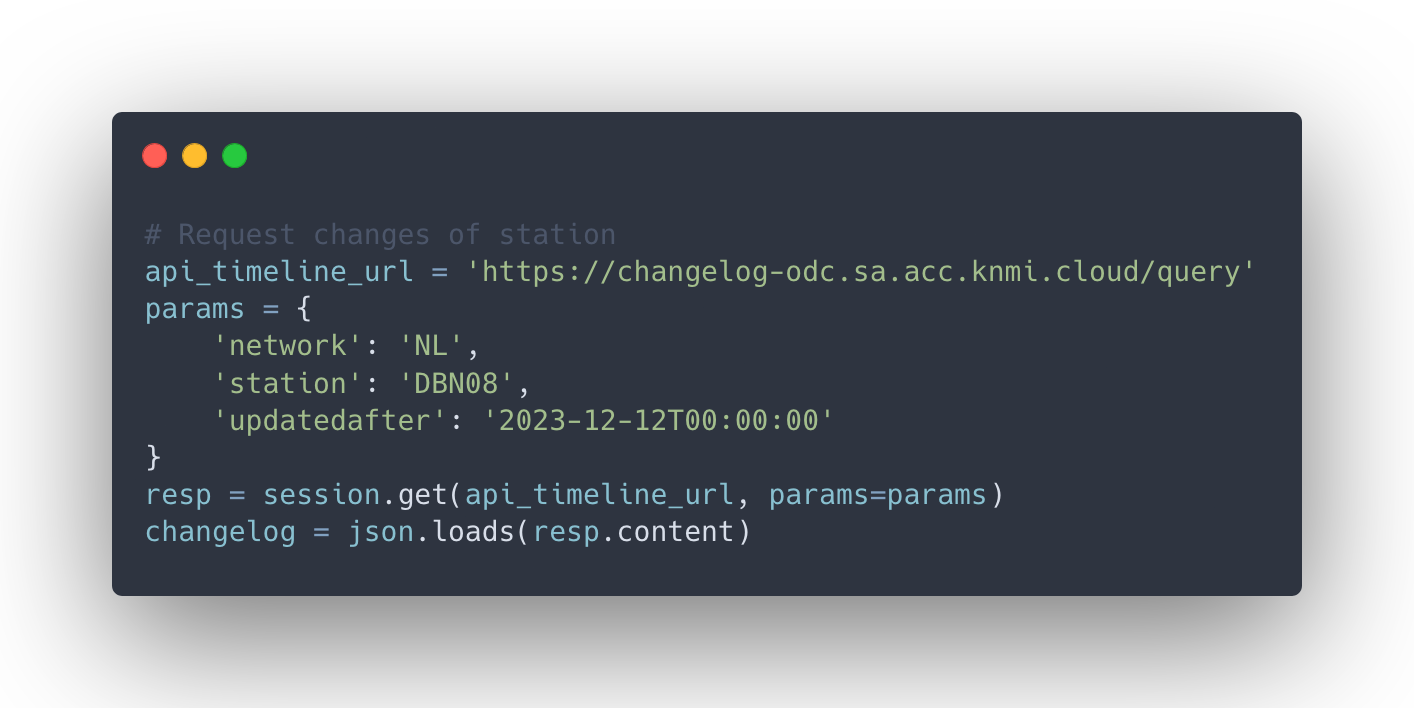

### Metadata
Get station metadata at given timestamp
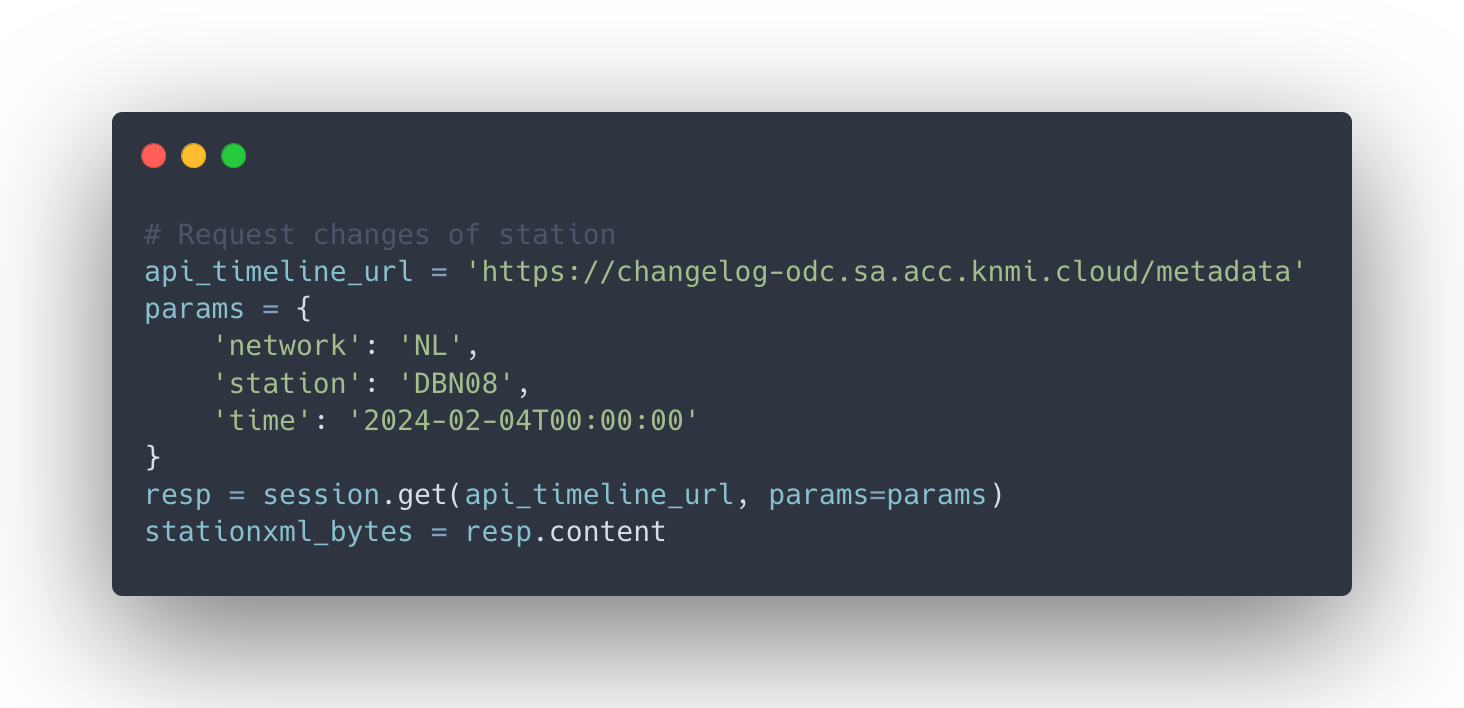

### Timeline
Get station metadata timeline
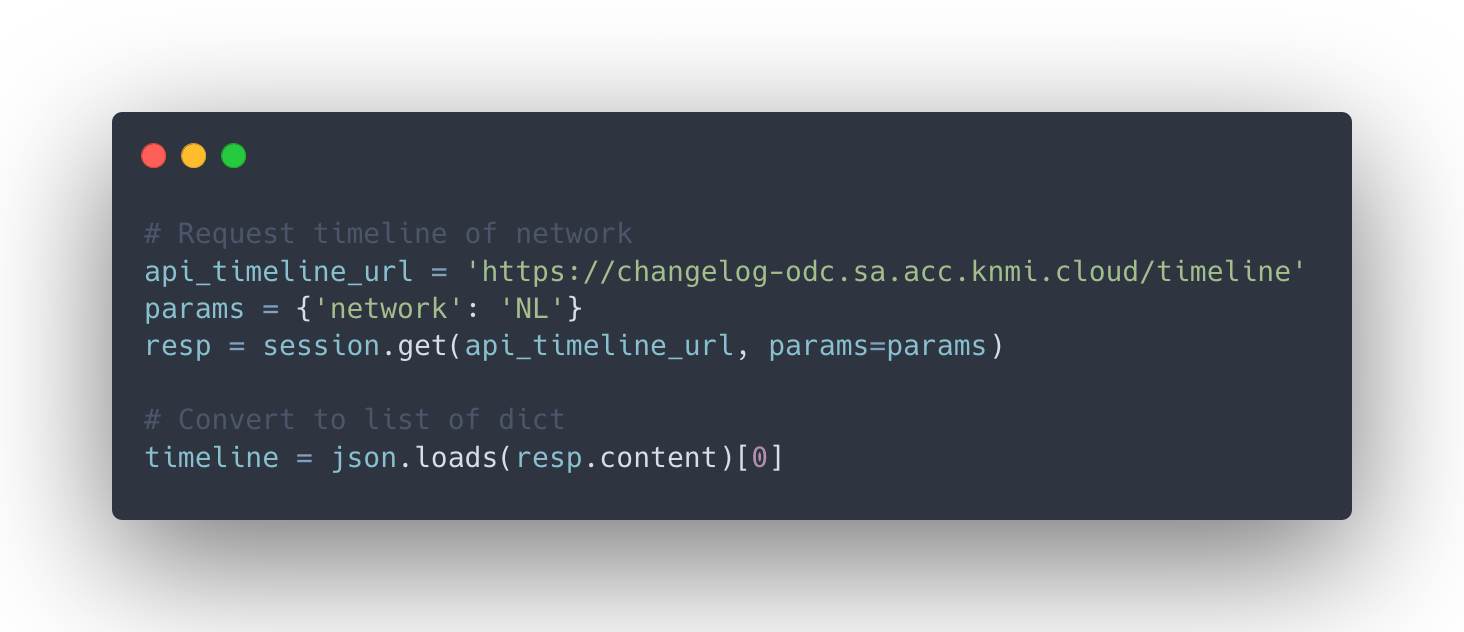

Changelog is created on request, based on metadata saved in database
- flexibility to adapt changelog exporting format for each agency
- the only data stored is station metadata (in StationXML)
- very simple codebase

# 3. Example: Station Metadata Changelog API request
___

## Timeline
Request metadata of all changes of a given network or station
Returns:
- network code
- network DOI
- list of station metadata, per station:
  - hash
  - id
  - fdsnws origin url
  - timestamp
  - url of stationxml file at timestamp

In [20]:
import requests
from requests.adapters import HTTPAdapter

# Create http session
session = requests.Session()
session.mount("http://", HTTPAdapter())

In [21]:
import json

# Request timeline of network
api_timeline_url = 'https://changelog-odc.sa.acc.knmi.cloud/timeline'
params = {'network': 'NL'}
resp = session.get(api_timeline_url, params=params)

# Convert to list of dict
changelog_NL = json.loads(resp.content)[0]

In [22]:
json_str = json.dumps(changelog_NL, indent=4)
print(json_str[:4000])

{
    "network_code": "NL",
    "network_doi": "10.21944/e970fd34-23b9-3411-b366-e4f72877d2c5",
    "stations": [
        {
            "logs": [
                {
                    "hash": "568b8f32e304268b0ab8deef2acc9848",
                    "id": 3522,
                    "origin": "http://orfeus-eu.org/fdsnws/station/1/query?network=NL&station=0171&level=response&format=xml",
                    "timestamp": "2023-12-23T22:29:39",
                    "url": "http://changelog-odc.sa.acc.knmi.cloud/metadata/3522"
                },
                {
                    "hash": "ea096daca66083494a404f2b025bc12f",
                    "id": 21704,
                    "origin": "http://orfeus-eu.org/fdsnws/station/1/query?network=NL&station=0171&level=response&format=xml",
                    "timestamp": "2024-01-13T22:32:18",
                    "url": "http://changelog-odc.sa.acc.knmi.cloud/metadata/21704"
                }
            ],
            "station_code": "0171"
       

In [23]:
# Request timeline of station
api_timeline_url = 'https://changelog-odc.sa.acc.knmi.cloud/timeline'
params = {'network': 'NL', 'station': 'DBN08'}
resp = session.get(api_timeline_url, params=params)
changelog = json.loads(resp.content)[0]

In [24]:
json_str = json.dumps(changelog, indent=4)
print(json_str)

{
    "network_code": "NL",
    "network_doi": "10.21944/e970fd34-23b9-3411-b366-e4f72877d2c5",
    "stations": [
        {
            "logs": [
                {
                    "hash": "023d91eb2a7c23d1b785978e23057039",
                    "id": 6811,
                    "origin": "http://orfeus-eu.org/fdsnws/station/1/query?network=NL&station=DBN08&level=response&format=xml",
                    "timestamp": "2023-12-23T22:58:07",
                    "url": "http://changelog-odc.sa.acc.knmi.cloud/metadata/6811"
                },
                {
                    "hash": "022118f3d13328c9dc6b73a850a75849",
                    "id": 25194,
                    "origin": "http://orfeus-eu.org/fdsnws/station/1/query?network=NL&station=DBN08&level=response&format=xml",
                    "timestamp": "2024-01-13T23:04:01",
                    "url": "http://changelog-odc.sa.acc.knmi.cloud/metadata/25194"
                },
                {
                    "hash": "5f2f60a

## Query

Query changelog of station, timeframe can be specified

Returns:
- changelog of station
- format can be agency specific
   - KNMI returns dictionary with 'Changed' and 'Added' keys

In [25]:
# Request changelog of station
api_timeline_url = 'https://changelog-odc.sa.acc.knmi.cloud/query'
params = {
    'network': 'NL',
    'station': 'DBN08',
    'updatedafter': '2023-12-12T00:00:00'
}
resp = session.get(api_timeline_url, params=params)
changelog = json.loads(resp.content)

In [26]:
json_str = json.dumps(changelog, indent=4)
print(json_str)

{
    "Changed": {
        "NL": {
            "DBN08": {
                "station_code.latitude": {
                    "New": "52.099134",
                    "Old": "52.098646"
                },
                "station_code.longitude": {
                    "New": "5.17972",
                    "Old": "5.176704"
                }
            }
        }
    },
    "Date": "Sat, 17 Feb 2024 22:41:00 GMT"
}


In [27]:
# Request changelog of station
api_timeline_url = 'https://changelog-odc.sa.acc.knmi.cloud/query'
params = {
    'network': 'NL',
    'station': 'DBN08',
    'updatedbefore': '2024-02-04T00:00:00',
}
resp = session.get(api_timeline_url, params=params)
changelog = json.loads(resp.content)

In [28]:
json_str = json.dumps(changelog, indent=4)
print(json_str)

{
    "Added": {
        "NL": {
            "DBN08": {
                "2023-01-02T14:34:00.000000Z": {
                    "02": [
                        ".02.CDF"
                    ]
                }
            }
        }
    },
    "Changed": {
        "NL": {
            "DBN08": {
                "station_code.latitude": {
                    "New": "52.099134",
                    "Old": "52.098646"
                },
                "station_code.longitude": {
                    "New": "5.17972",
                    "Old": "5.176704"
                }
            }
        }
    },
    "Date": "Sat, 03 Feb 2024 22:41:53 GMT"
}


In [29]:
# Request changelog of station
api_timeline_url = 'https://changelog-odc.sa.acc.knmi.cloud/query'
params = {
    'network': 'NL',
    'station': 'DBN08',
    'updatedafter': '2023-12-12T00:00:00',
    'updatedbefore': '2024-02-04T00:00:00'
}
resp = session.get(api_timeline_url, params=params)
changelog = json.loads(resp.content)

In [30]:
json_str = json.dumps(changelog, indent=4)
print(json_str)

{
    "Added": {
        "NL": {
            "DBN08": {
                "2023-01-02T14:34:00.000000Z": {
                    "02": [
                        ".02.CDF"
                    ]
                }
            }
        }
    },
    "Changed": {
        "NL": {
            "DBN08": {
                "station_code.latitude": {
                    "New": "52.099134",
                    "Old": "52.098646"
                },
                "station_code.longitude": {
                    "New": "5.17972",
                    "Old": "5.176704"
                }
            }
        }
    },
    "Date": "Sat, 03 Feb 2024 22:41:53 GMT"
}


## Metadata

Query metadata of station at a certain time

Returns:
- Stationxml bytes of station metadata

In [31]:
# Request StationXML of station
api_timeline_url = 'https://changelog-odc.sa.acc.knmi.cloud/metadata'
params = {
    'network': 'NL',
    'station': 'DBN08',
    'time': '2024-02-04T00:00:00'
}
resp = session.get(api_timeline_url, params=params)
inventory_xml = resp.content.decode('utf-8')

In [32]:
import xml.etree.ElementTree as ET

# Print out xml string
inventory_xml_tree = ET.fromstring(inventory_xml)
ET.indent(inventory_xml_tree)
print(ET.tostring(inventory_xml_tree, encoding='unicode'))

<FDSNStationXML xmlns="http://www.fdsn.org/xml/station/1" schemaVersion="1.1">
  <Source>SeisComP</Source>
  <Sender>ODC</Sender>
  <Created>2023-12-23T22:58:06.924197</Created>
  <Network code="NL" startDate="1993-01-01T00:00:00" restrictedStatus="open">
    <Description>Netherlands Seismic and Acoustic Network</Description>
    <Identifier type="DOI">10.21944/e970fd34-23b9-3411-b366-e4f72877d2c5</Identifier>
    <Station code="DBN08" startDate="2021-06-14T10:57:00" restrictedStatus="open">
      <Latitude>52.098646</Latitude>
      <Longitude>5.176704</Longitude>
      <Elevation>2</Elevation>
      <Site>
        <Name>De Bilt Infrasound Array</Name>
        <Country>The Netherlands</Country>
      </Site>
      <Vault>1.0</Vault>
      <CreationDate>2021-06-14T10:57:00</CreationDate>
      <Channel code="HDF" startDate="2022-04-11T10:24:00" endDate="2022-04-14T15:40:00" locationCode="02">
        <Latitude>52.0985679</Latitude>
        <Longitude>5.1766855</Longitude>
        <Elev

## Finally:
If there is interested, we can share the code
- Needs fdsnws and docker
- Works with xmldiff or sicu (right now internal KNMI repo)
